In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

from PIL import Image
from typing import cast, Any, Union, Dict, List
import time
import random
import copy 
 
import matplotlib.pyplot as plt

import os
import shutil
from collections import OrderedDict



device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Loading data

**Let's see what the data in the pandas table looks like**

In [ ]:
# import data
train_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              train=False,
                                              transform=transforms.Compose([transforms.ToTensor()]))

train_set, val_set = torch.utils.data.random_split(train_set, [int(len(train_set) * 0.8), int(len(train_set) * 0.2)])

train_dataloader = torch.utils.data.DataLoader(train_set,
                                        batch_size = 100,
                                        shuffle = True)

val_dataloader = torch.utils.data.DataLoader(val_set,
                                        batch_size = 100)

loaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
#for metrics
dataset_sizes = { 'train': len(train_set), 'val': len(val_set)}

**Let's see what the images look like**

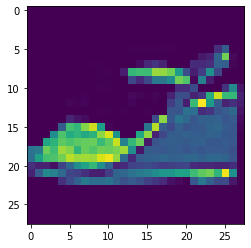

In [ ]:
i = np.random.randint(50)
x, y = next(iter(train_dataloader))
plt.imshow(x[i].view(28,28))

# Model

**For the FashionMNIST classification, I decided to use VGG, but I changed the source code a bit (source code: https://pytorch.org/vision/stable/_modules/torchvision/models/vgg.html). I would like to note that I initialized the weights according to Kaiming initialization and PReLU instead of ReLU. This really makes the result better. You can read more about Kaiming initialization here: https://arxiv.org/abs/1502.01852v1, https://towardsdatascience.com/understand-kaiming-initialization-and-implementation-detail-in-pytorch-f7aa967e9138. I advise you to read both articles, since one of them is a theory, and the other is an implementation.**

In [ ]:
class VGG(nn.Module):
  def __init__(self, features:nn.Module, num_classes:int=1000, init_weights:bool=True):
      super(VGG, self).__init__()
      self.features = features #features = Feature extraction
      self.avgpool = nn.AdaptiveAvgPool2d((1,1))
      self.classifier = nn.Sequential(
          nn.Linear(256, 128),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(64, num_classes)
          )

      if init_weights:
        self.initialize_weights()
  
  def forward(self, x):
    x = self.features(x) #features = Feature extraction
    x = self.avgpool(x)
    # print(x.shape)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0) 
      if isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0) 

cfgs: Dict[str, List[Union[int, str]]] = {
    'A':[64, 'M', 128, 128, 'M', 256, 256, 256],
    'B':[16, 'M', 256, 'M'],
    'firstPadding':2
}
# cfgs: Dict[str, List[Union[str, int]]] = {
#     'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
#     'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
# }



def make_layers(cfg:List[Union[int,str]], batch_norm:bool=False) -> nn.Sequential:
  layers:List[nn.Moduel] = []
  in_channels = 1
  in_padding = 5
  i = 0
  for v in cfg:
    if v == 'M':
      layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    else:
      v = cast(int, v)
      in_padding = 1
      if i == 5:
        in_padding = 2
      conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=in_padding)
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(v), nn.PReLU(num_parameters=1)]
      else:
        layers += [conv2d, nn.PReLU(num_parameters=1)] #nn.PReLU(num_parameters=1) nn.ReLU(inplace=True)
      in_channels = v
    i += 1
  return nn.Sequential(*layers)


def selfDefineVgg(arch, cfg, batch_norm,  num_classes:int, **kwargs: Any) -> VGG:
    model = VGG(make_layers(arch[cfg], batch_norm=batch_norm), num_classes, **kwargs)
    return model
model = selfDefineVgg(cfgs, 'A', True, 10)
model = model.to(device)

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): PReLU(num_parameters=1)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): PReLU(num_parameters=1)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): PReLU(num_parameters=1)
  

**Loss function, Optimizer, Scheduler**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9,0.999), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1, verbose=False)###Best accuracy 0.9349, tensor(0.9385)

# Train

In [ ]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(float(epoch_loss))
      accuracies[phase].append(float(epoch_acc))
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

**Launching training**

In [ ]:
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/10
train - loss:0.5768990177971621, accuracy0.7981041666666666
val - loss:0.375209712361296, accuracy0.8701666666666666
Time: 0.0m 25.607548713684082s
Epoch: 2/10
train - loss:0.33081146320328114, accuracy0.8823958333333333
val - loss:0.33776357273260754, accuracy0.8867499999999999
Time: 0.0m 42.68583703041077s
Epoch: 3/10
train - loss:0.26846604207530617, accuracy0.9062916666666666
val - loss:0.2844021371255318, accuracy0.9007499999999999
Time: 1.0m 0.7080113887786865s
Epoch: 4/10
train - loss:0.23468020039921006, accuracy0.91625
val - loss:0.25355341465522846, accuracy0.90925
Time: 1.0m 17.97537088394165s
Epoch: 5/10
train - loss:0.1698779801217218, accuracy0.9399166666666666
val - loss:0.18545684789617856, accuracy0.9331666666666666
Time: 1.0m 35.27368879318237s
Epoch: 6/10
train - loss:0.14631770154616486, accuracy0.9475208333333333
val - loss:0.19403339449005821, accuracy0.93225
Time: 1.0m 52.4868369102478s
Epoch: 7/10
train - loss:0.13134383705134192, accuracy0.953125
va

**Visualization**

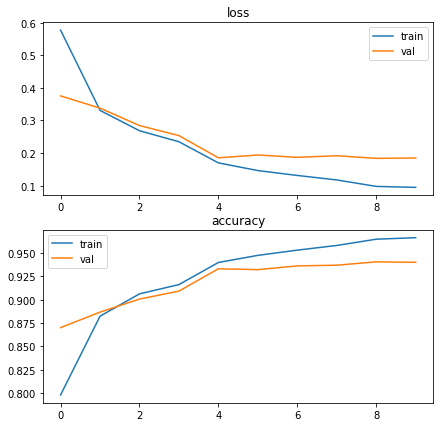

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

fig, axs = plt.subplots(2)

axs[0].plot([x for x in range(epochs)], losses['train'], label ='train')
axs[0].plot([x for x in range(epochs)], losses['val'], label='val')
axs[0].set_title('loss')
axs[0].legend()

axs[1].plot([x for x in range(epochs)], accuracies['train'], label ='train')
axs[1].plot([x for x in range(epochs)], accuracies['val'], label='val')
axs[1].set_title('accuracy')
axs[1].legend()

# Test

**Uploading the data**

In [ ]:
loadersq=  DataLoader(test_set, batch_size=100, shuffle = True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Creating a dictionary with the size of the test dataset.**

In [ ]:
dataset_sizesq = len(test_set)
dataset_sizesq

10000

**Similarly, we calculate the average and standard deviation for test**

In [ ]:
num_px = dataset_sizesq*28*28


total_sum = 0
for batch in loadersq: total_sum += batch[0].sum()
mean = total_sum / num_px

sum_of_squared_error = 0
for batch in loadersq: sum_of_squared_error += ((batch[0] - mean).pow(2)).sum()
std = torch.sqrt(sum_of_squared_error / num_px)

mean, std

(tensor(0.2868), tensor(0.3524))

**Predictions**

In [ ]:
corr = 0
 
with torch.no_grad(): 
    for data in loadersq:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y_pred = model(images) 
        _, predicted = torch.max(y_pred, 1) 
        corr += torch.sum(predicted == labels.data)
 
print(f"Test accuracy: {corr/dataset_sizesq}")

Test accuracy: 0.9298999905586243


In [ ]:
from torch.autograd import Variable

def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in loadersq:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 88.00%
Accuracy of Trouser: 99.20%
Accuracy of Pullover: 89.90%
Accuracy of Dress: 93.10%
Accuracy of Coat: 90.60%
Accuracy of Sandal: 98.50%
Accuracy of Shirt: 77.50%
Accuracy of Sneaker: 97.70%
Accuracy of Bag: 99.10%
Accuracy of Ankle Boot: 96.30%


## Predict with Jury Test

In [ ]:
# def resize_image(src_image, size=(128,128), bg_color='white'): 
#     from PIL import Image, ImageOps 
    
#     # resize the image so the longest dimension matches our target size
#     src_image.thumbnail(size, Image.ANTIALIAS)
    
#     # Create a new square background image
#     new_image = Image.new("RGB", size, bg_color)
    
#     # Paste the resized image into the center of the square background
#     new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
#     # return the resized image
#     new_image = Image.open(src_image).convert('L')
#     return new_image

In [ ]:
import numpy as np
import cv2

def resize_to_28x28(img):
    img_h, img_w = img.shape
    dim_size_max = max(img.shape)

    if dim_size_max == img_w:
        im_h = (26 * img_h) // img_w
        if im_h <= 0 or img_w <= 0:
            print("Invalid Image Dimention: ", im_h, img_w, img_h)
        tmp_img = cv2.resize(img, (26,im_h),0,0,cv2.INTER_NEAREST)
    else:
        im_w = (26 * img_w) // img_h
        if im_w <= 0 or img_h <= 0:
            print("Invalid Image Dimention: ", im_w, img_w, img_h)
        tmp_img = cv2.resize(img, (im_w, 26),0,0,cv2.INTER_NEAREST)

    out_img = np.zeros((28, 28), dtype=np.ubyte)

    nb_h, nb_w = out_img.shape
    na_h, na_w = tmp_img.shape
    y_min = (nb_w) // 2 - (na_w // 2)
    y_max = y_min + na_w
    x_min = (nb_h) // 2 - (na_h // 2)
    x_max = x_min + na_h

    out_img[x_min:x_max, y_min:y_max] = tmp_img

    return out_img


In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
def pre_image(image_path,model):
   img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
   img = resize_to_28x28(img)
  #  img = cv.bitwise_not(img)
   cv2_imshow(img)
   #img = Image.open(image_path)
   transform_norm = transforms.Compose([transforms.ToTensor(), 
   transforms.Resize((28,28))])
   # get normalized image
   img_normalized = transform_norm(img).float()
   img_normalized = img_normalized.unsqueeze_(0)
   # input = Variable(image_tensor)
   img_normalized = img_normalized.to(device)
   # print(img_normalized.shape)
   with torch.no_grad():
      model.eval()  
      output =model(img_normalized)
     # print(output)
      index = output.data.cpu().numpy().argmax()
      classes = ['T-shirt/Top','Trouser','PullOver','Dress','Coat','Sandal','Shirt', 'Sneaker','Bag','Ankle Bot']
      class_name = classes[index]
      return class_name

In [ ]:
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  predict_class = pre_image(fn,model)
  print(predict_class)

Saving Screenshot_3.png to Screenshot_3.png


Coat


## Save Model

In [ ]:
# model.cpu()
torch.save({'arch': 'vgg',
            'state_dict': model.state_dict()},
            'classifier.pth')